<a href="https://colab.research.google.com/github/JauntyPaul/JauntyPaul/blob/main/IIITHSpeakerRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.10

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
try:
    from spela.spectrogram import Spectrogram
    from spela.melspectrogram import Melspectrogram
except:
    !pip install spela
    from spela.spectrogram import Spectrogram
    from spela.melspectrogram import Melspectrogram



In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

tf.compat.v1.disable_eager_execution()
# Get the data directories
data_dir = "/content/drive/MyDrive/IIITH/16000_pcm_speeches"


In [ ]:
os.listdir(data_dir)

['tf_Wav_reader.py',
 'Nelson_Mandela',
 'Julia_Gillard',
 '_background_noise_',
 'Magaret_Tarcher',
 'Jens_Stoltenberg',
 'other',
 'Benjamin_Netanyau']

In [ ]:

# for now we are concerned with the four speakers
# lets get as a sample data from one of the speakers
nelson_madela = [item for item in os.listdir(data_dir + "/Nelson_Mandela")]
nelson_madela[:10]

['1459.wav',
 '1457.wav',
 '1192.wav',
 '1209.wav',
 '1484.wav',
 '130.wav',
 '1030.wav',
 '1329.wav',
 '1092.wav',
 '163.wav']

In [ ]:
def compute_spectrogram_melspectrogram_and_plot(wav_dir, compute_type):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
        wav_decoder, feed_dict={
            wav_filename_placeholder: wav_dir
        }).audio.flatten()
        sess.close()
    # audio has a sample rate of 16000 and the produced wav has a shape of (16000, 1)
    # reshape to (1, 1600)
    wav = wav_data.reshape(1, 16000)
    wav_new = wav[np.newaxis, :] # introduce a new axis to have a shape of (1, 1, 16000)
    height = wav_new.shape[1]
    width = wav_new.shape[2]
# create a model to compute spectrogram
    model = tf.keras.Sequential()
    if compute_type == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(height, width),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif compute_type == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(height, width), return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))

    # producing a spectrogram/melspectrogram from the model
    pred = model.predict(x=wav_new)

    if tf.keras.backend.image_data_format() == "channel_first":
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
# show the spectrogram/melspectrogram
    librosa.display.specshow(result, y_axis='linear', sr=16000)


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


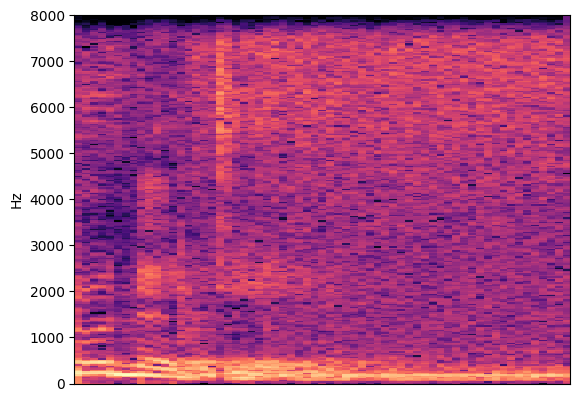

In [ ]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "/Nelson_Mandela/" + nelson_madela[0], "spectrogram")


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


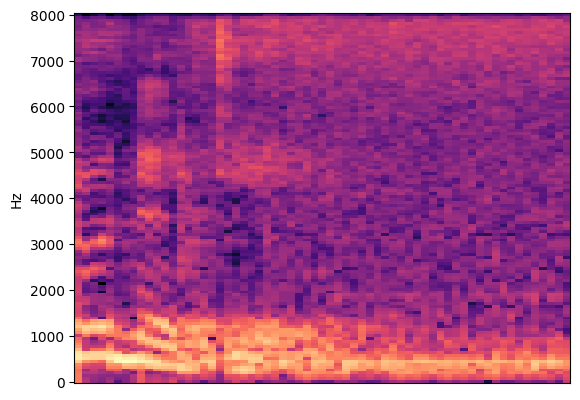

In [ ]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "/Nelson_Mandela/" + nelson_madela[0], "melspectrogram")

In [ ]:
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [ ]:
nelson_mandela_paths = get_wav_paths("/Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("/Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("/Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( '/Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("/Julia_Gillard")


In [ ]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir +speaker + "/"+ wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data


In [ ]:

# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels


In [ ]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "/Nelson_Mandela", 0)
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "/Magaret_Tarcher", 1)
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "/Benjamin_Netanyau", 2)
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "/Jens_Stoltenberg", 3)
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "/Julia_Gillard", 4)


100%|██████████| 1501/1501 [08:48<00:00,  2.84it/s]


In [ ]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]



In [ ]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels



In [ ]:

# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)



In [ ]:

train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)


In [ ]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [ ]:
# create a model
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(1, 16000),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif speech_feature == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(1 , 16000),return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))


    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

In [ ]:
# spectrogam model
model = create_model("spectrogram")

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 static_stft (Spectrogram)   (None, 257, 63, 1)        263168    
                                                                 
 conv2d (Conv2D)             (None, 255, 61, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 30, 64)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 243840)            0         
                                                                 
 dense (Dense)               (None, 5)                 1219205   
                                                                 
Total params: 1,483,013
Trainable params: 1,483,013
Non-trainable params: 0
____________________________________________

In [ ]:
model.fit(x=train_x, y=train_y, epochs=10, validation_data=(test_x, test_y))

Train on 6008 samples, validate on 1502 samples
Epoch 1/10
6008/6008 [==============================] - ETA: 0s - loss: 37.0501 - accuracy: 0.5994

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6008/6008 [==============================] - 156s 26ms/sample - loss: 37.0501 - accuracy: 0.5994 - val_loss: 1.7520 - val_accuracy: 0.7543
Epoch 2/10
6008/6008 [==============================] - 167s 28ms/sample - loss: 3.0673 - accuracy: 0.8109 - val_loss: 0.7090 - val_accuracy: 0.8888
Epoch 3/10
6008/6008 [==============================] - 156s 26ms/sample - loss: 0.2784 - accuracy: 0.9546 - val_loss: 0.3502 - val_accuracy: 0.9407
Epoch 4/10
6008/6008 [==============================] - 157s 26ms/sample - loss: 0.0304 - accuracy: 0.9925 - val_loss: 0.7276 - val_accuracy: 0.8981
Epoch 5/10
6008/6008 [==============================] - 157s 26ms/sample - loss: 0.0752 - accuracy: 0.9817 - val_loss: 0.8805 - val_accuracy: 0.8728
Epoch 6/10
6008/6008 [==============================] - 157s 26ms/sample - loss: 0.5095 - accuracy: 0.9417 - val_loss: 0.7539 - val_accuracy: 0.8901
Epoch 7/10
6008/6008 [==============================] - 157s 26ms/sample - loss: 0.1229 - accuracy: 0.9764 - val_los

In [ ]:
# Choose a meaningful path to save the model
model_path = "/content/drive/MyDrive/IIITH"  # Replace with your desired path

# Save the model
model.save(model_path)

In [ ]:
model.input_shape

(None, 1, 16000)

In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from spela.spectrogram import Spectrogram
from spela.melspectrogram import Melspectrogram
from tqdm import tqdm

# Define data augmentation function for spectrograms
def augment_spectrogram(spectrogram):
    # Apply augmentation techniques here
    # Example: Add random noise
    augmented_spectrogram = spectrogram + np.random.normal(0, 0.05, spectrogram.shape)
    return augmented_spectrogram

# Define function to generate spectrogram from audio file
def generate_spectrogram(audio_file):
    audio, sr = librosa.load(audio_file, sr=16000)
    spectrogram = np.abs(librosa.stft(audio, n_fft=512, hop_length=256))
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return spectrogram

# Load the data
def load_data(data_dir):
    speakers = ["Nelson_Mandela", "Magaret_Tarcher", "Benjamin_Netanyau", "Jens_Stoltenberg", "Julia_Gillard"]
    X, y = [], []
    for label, speaker in enumerate(speakers):
        speaker_path = os.path.join(data_dir, speaker)
        audio_files = os.listdir(speaker_path)
        for audio_file in tqdm(audio_files, desc=speaker):
            spectrogram = generate_spectrogram(os.path.join(speaker_path, audio_file))
            augmented_spectrogram = augment_spectrogram(spectrogram)
            X.append(augmented_spectrogram)
            y.append(label)
    return np.array(X), np.array(y)

# Load and augment the data
X, y = load_data(data_dir)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


Julia_Gillard: 100%|██████████| 1501/1501 [00:28<00:00, 53.13it/s] 


In [ ]:
# Predicting on test data
predictions = model.predict(test_x)

# Decoding predictions to speaker labels
predicted_speakers = np.argmax(predictions, axis=1)

# Define a dictionary to map labels back to speaker names
label_to_speaker = {
    0: "Nelson Mandela",
    1: "Margaret Thatcher",
    2: "Benjamin Netanyahu",
    3: "Jens Stoltenberg",
    4: "Julia Gillard"
}

# Decoding predicted labels to speaker names
predicted_speakers_names = [label_to_speaker[label] for label in predicted_speakers]

# Displaying the actual and predicted speakers
for i in range(len(test_labels)):
    actual_speaker = label_to_speaker[test_labels[i]]
    predicted_speaker = predicted_speakers_names[i]
    print(f"Actual Speaker: {actual_speaker}, Predicted Speaker: {predicted_speaker}")



Actual Speaker: Jens Stoltenberg, Predicted Speaker: Jens Stoltenberg
Actual Speaker: Jens Stoltenberg, Predicted Speaker: Jens Stoltenberg
Actual Speaker: Julia Gillard, Predicted Speaker: Julia Gillard
Actual Speaker: Julia Gillard, Predicted Speaker: Jens Stoltenberg
Actual Speaker: Benjamin Netanyahu, Predicted Speaker: Benjamin Netanyahu
Actual Speaker: Nelson Mandela, Predicted Speaker: Nelson Mandela
Actual Speaker: Benjamin Netanyahu, Predicted Speaker: Benjamin Netanyahu
Actual Speaker: Jens Stoltenberg, Predicted Speaker: Jens Stoltenberg
Actual Speaker: Julia Gillard, Predicted Speaker: Julia Gillard
Actual Speaker: Jens Stoltenberg, Predicted Speaker: Jens Stoltenberg
Actual Speaker: Margaret Thatcher, Predicted Speaker: Margaret Thatcher
Actual Speaker: Nelson Mandela, Predicted Speaker: Nelson Mandela
Actual Speaker: Julia Gillard, Predicted Speaker: Julia Gillard
Actual Speaker: Benjamin Netanyahu, Predicted Speaker: Benjamin Netanyahu
Actual Speaker: Benjamin Netanyahu,

In [ ]:
from sklearn.metrics import accuracy_score

# Convert actual labels to speaker names
actual_speakers_names = [label_to_speaker[label] for label in test_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_speakers_names, predicted_speakers_names)

print("Accuracy:", accuracy)


Accuracy: 0.8415446071904128
